# Q6 PCA + Classification

## 6.1 Data Loading and Preparation & 6.2 Dimensionality Reduction with PCA

### Import necessary libraries

In [18]:
import numpy as np
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

### PCA_KNN Class

In [19]:
class PCA:
    """
    Custom Implementation of Principal Component Analysis (PCA).

    n_components : int
        Number of principal components to keep.
    """

    def __init__(self, n_components: int):
        """
        Initialize PCA with the desired number of components.

        n_components : int
            The number of dimensions to reduce the data to.
        """
        self.n_components = n_components
        self.mean = None
        self.components = None
        self.explained_variance = None

    def fit(self, X: np.ndarray):
        """
        Fit the PCA model to the dataset by computing principal components.

        X : np.ndarray, shape (n_samples, n_features)
            The dataset to fit.

        Returns
        -------
        self : PCA
            Fitted PCA model.
        """
        # Center the data
        self.mean = np.mean(X, axis=0)
        X_centered = X - self.mean

        # Compute covariance matrix
        cov_matrix = np.cov(X_centered, rowvar=False)

        # Compute eigenvalues and eigenvectors
        eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)

        # Sort eigenvalues (descending) and corresponding eigenvectors
        sorted_idx = np.argsort(eigenvalues)[::-1]
        eigenvalues = eigenvalues[sorted_idx]
        eigenvectors = eigenvectors[:, sorted_idx]

        # Keep only the top n_components
        self.explained_variance = eigenvalues[:self.n_components]
        self.components = eigenvectors[:, :self.n_components]

        return self

    def transform(self, X: np.ndarray) -> np.ndarray:
        """
        Transform the dataset into the reduced dimension space.

        X : np.ndarray, shape (n_samples, n_features)
            The dataset to transform.

        Returns
        -------
        X_transformed : np.ndarray, shape (n_samples, n_components)
            Transformed dataset with reduced dimensions.
        """
        if self.mean is None or self.components is None:
            raise RuntimeError("PCA model has not been fitted yet. Call fit() before transform().")

        X_centered = X - self.mean
        X_transformed = np.dot(X_centered, self.components)

        return X_transformed

    def checkPCA(self, X: np.ndarray) -> bool:
        """
        Check if PCA reduces the dataset to the required dimensions.

        X : np.ndarray, shape (n_samples, n_features)
            Dataset to check PCA on.

        Returns
        -------
        result : bool
            True if PCA reduces dimensions correctly, False otherwise.
        """
        transformed = self.transform(X)
        return transformed.shape[1] == self.n_components

### PCAHandler Class

In [20]:
class PCA_KNN:
    """
    Handles PCA-based dimensionality reduction for the MNIST digits dataset.
    Uses the custom PCA implementation provided earlier (assumed as PCA class).
    """

    def __init__(self, n_components_list, random_state=42, test_size=0.2):
        """
        Initialize the PCA handler.

        n_components_list : list
            List of dimensions to reduce the data to.
        random_state : int
            Random seed for reproducibility in train-test split.
        test_size : float
            Fraction of dataset to be used for testing.
        """
        self.n_components_list = n_components_list
        self.random_state = random_state
        self.test_size = test_size

        # Load and prepare the dataset
        self.X_train, self.X_test, self.y_train, self.y_test = self.load_and_split_data()
        self.X_train -= np.mean(self.X_train, axis=0)
        self.X_test -= np.mean(self.X_test, axis=0)
    
    def accuracy_score(self, y_true, y_pred):
        """
        Custom implementation of accuracy score.

        y_true : array-like
            True class labels.
        y_pred : array-like
            Predicted class labels.
        
        Returns
        -------
        accuracy : float
            Fraction of correctly classified samples.
        """
        # Convert to numpy arrays for easy element-wise comparison
        y_true = np.array(y_true)
        y_pred = np.array(y_pred)
        
        correct = np.sum(y_true == y_pred)
        accuracy = correct / len(y_true)        
        return accuracy

    def load_and_split_data(self):
        """
        Load MNIST 8x8 dataset and split into training and testing sets.

        Returns
        -------
        X_train, X_test, y_train, y_test : tuple
            Training and testing splits of the dataset.
        """
        digits = load_digits()
        X = digits.data
        y = digits.target
        return train_test_split(X, y, test_size=self.test_size,
                                random_state=self.random_state, stratify=y)

    def apply_pca(self, pca_class):
        """
        Apply custom PCA for each n_components value in the list.

        pca_class : class
            Custom PCA implementation (must have fit_transform and transform methods).

        Returns
        -------
        dict
            A dictionary mapping n_components -> (X_train_reduced, X_test_reduced).
        """
        reduced_data = {}

        for n_components in self.n_components_list:
            pca = pca_class(n_components=n_components)
            X_train_reduced = pca.fit(self.X_train).transform(self.X_train)
            X_test_reduced = pca.transform(self.X_test)

            reduced_data[n_components] = (X_train_reduced, X_test_reduced)
        
        return reduced_data
    
    def evaluate_knn_classification(self, reduced_data, y_train, y_test, k_values):
        """
        Evaluate KNN classifier on PCA-reduced datasets.

        reduced_data : dict
            Dictionary mapping n_components -> (X_train_reduced, X_test_reduced).
        y_train : np.ndarray
            Training labels.
        y_test : np.ndarray
            Testing labels.
        k_values : list
            List of k values (number of neighbors) to evaluate.

        Returns
        -------
        results : dict
            Nested dictionary mapping:
            n_components -> {k: accuracy_score}
        """
        results = {}

        for n_components, (X_train_reduced, X_test_reduced) in reduced_data.items():
            results[n_components] = {}
            for k in k_values:
                # Initialize KNN
                knn = KNeighborsClassifier(n_neighbors=k)

                # Train on reduced training data
                knn.fit(X_train_reduced, y_train)

                # Predict on reduced testing data
                y_pred = knn.predict(X_test_reduced)

                # Compute accuracy
                acc = self.accuracy_score(y_test, y_pred)
                results[n_components][k] = acc

        return results

    def plot_knn_results(self,  results, k_values):
        """
        Plot classification accuracy vs number of principal components
        for different k values.

        results : dict
            Nested dictionary mapping n_components -> {k: accuracy_score}.
        k_values : list
            List of k values used for classification.
        """
        n_components_list = sorted(results.keys())

        plt.figure(figsize=(10, 6))

        for k in k_values:
            accuracies = [results[n][k] * 100 for n in n_components_list]
            plt.plot(n_components_list, accuracies, marker="o", label=f"k={k}")

        plt.title("KNN Classification Accuracy vs Number of PCA Components", fontsize=16)
        plt.xlabel("Number of PCA Components", fontsize=14)
        plt.ylabel("Accuracy (%)", fontsize=14)
        plt.legend()
        plt.grid(True)
        plt.text(
            0.97, 0.99, "m.samartha",
            ha='right', va='top',
            transform=plt.gca().transAxes,
            fontsize=10, color='gray', alpha=0.7
        )
        plt.show()

In [21]:
# Preprocessing and PCA
n_components_list = [2, 5, 10, 20, 30, 40, 50, 64]
pca_handler = PCA_KNN(n_components_list=n_components_list)
reduced_results = pca_handler.apply_pca(PCA)
print("PCA applied and data reduced.")

PCA applied and data reduced.


## 6.3 Classification with KNN

In [22]:
# KNN classification
k_values = [5, 25, 50, 100]
knn_results = pca_handler.evaluate_knn_classification(
    reduced_results, pca_handler.y_train, pca_handler.y_test, k_values
)
print("KNN classification completed.")

KNN classification completed.


## 6.4 Visualization and Analysis 

Results plotted.


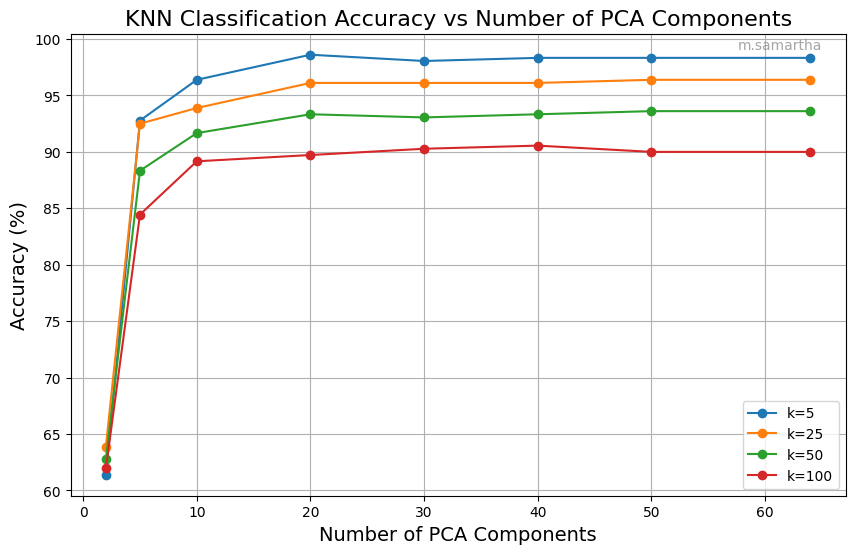

In [23]:
# Visualization
print("Results plotted.")
pca_handler.plot_knn_results(knn_results, k_values)